# Analisys of Heart Diseases dataset
###### by Mieuli Valerio | Polytechinc of Turin - s251372

## 1 - Introduction
The datasets analized in this report can be found with the prefrix "preprocessed" at <https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/>. There are four datasets with the same structure coming from different laboratories and we will simply merge them into a single one. We consider the "preprocessed" datasets because they have less features than the original ones. Infact interesting features like _patientID_ or _patientName_ have been removed. The considered features wich describe the patients are the following 14:
- _age_ - age in years
- _sex_ - sex
    * 0: female
    * 1: male
- _cp_ - chest pain type 
    * 1: typical angina 
    * 2: atypical angina 
    * 3: non-anginal pain 
    * 4: asymptomatic
- _trestbps_ - resting blood pressure (in mm Hg on admission to the hospital)
- _chol_ - serum cholestoral in mg/dl
- _fbs_ - fasting blood sugar
    * 1: > 120 mg/dl
    * 0: otherwise
- _restecg_ - resting electrocardiographic results
    * 0: normal
    * 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- _thalach_ - maximum heart rate achieved
- _exang_ - exercise induced angina
    * 0: no
    * 1: yes
- _oldpeak_ - ST depression induced by exercise relative to rest
- _slope_ - the slope of the peak exercise ST segment 
    * 1: upsloping 
    * 2: flat
    * 3: downsloping
- _ca_ - number of major vessels (0-3) colored by flourosopy
- _thal_ - thalassemias 
    * 3: normal
    * 6: fixed defect
    * 7: reversable defect
- _num_ - diagnosis of heart disease (class o the object) 
    * 0: NO disease
    * 1, 2, 3, 4: disease

Notice that we have only two classes, therefore our problem is a binary classification one and our goal is to build and compare different models using known classification algorithms which will be able to predict, given the information of a new patient as input, wheter he would have or not a heart disease. We start explaining which libraries have been used for ou purposes.

_NumPy_ is the fundamental package for scientific computing with Python. We use it mostly for general operations involving arrays.

In [32]:
import numpy as np

_Pandas_ is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language. We use it to easily represent and access the input dataset and to perform SQL-like operations on it.

In [33]:
import pandas as pd

_Matplotlib_ is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.
_Seaborn_ is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. We use them for data visualization by means of nice charts.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

_Scikit-learn_ is a very rich open source Python library for machine learning based on _NumPy_, _matplotlib_ and _SciPy_. It provides implementations for very many tools used for data mining and data analysis like classification, preprocessing, model selection, clustering, etc. We use some parts of this library in ou report.

The _hierarchy_ module of the _scipy.cluster_ library includes some functions concerning hierarchical clustering. We use them to run the hierarchical clustering algorithm and to show the correspondin dendrogram.

In [35]:
from scipy.cluster import hierarchy

The *model_selection* part includes tools to select a model including choosing the best paramenters for an algorithm (with K-Cross Validation for example) and compare the behaviour of different algorithms on the same data (with Learning Curve for example)

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

The _tree_ part includes tools to handle trees (either for classification and for regression one).
The _graphviz_ library (not included in _Scikit-learn_) facilitates the creation and rendering of graph descriptions in the DOT language of the Graphviz graph drawing software from Python and we use it to visualize the tree created using the _Scikit-learn_ tools.

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

The _ensemble_ part includes implementations on ensamble methods (_bagging_, _boosting_, etc) whose goal is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

In [38]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

The _metrics_ part includes score functions, performance metrics and pairwise metrics and distance computations. We use it for the *confusion_matrix* tool.

In [39]:
from sklearn.metrics import confusion_matrix

The _svm_, _neighbors_ and *linear_model* parts include implementations of classifier and regressor and in partiuclar we are interested in _Support Vector_, _K-Nearest Neighbor_ and _Logistic Regression_ classifier. 

In [40]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Here we just import the _warnings_ library and we use it to filter any kind of warning.

In [41]:
import warnings
warnings.filterwarnings('ignore')

Let us start with the initialization of some parameters like:
- path of the source datasets;
- list of attributes (also lists of them separated according the type of the attributes);
- a _SEED_ variable in order to execute random but repeatable experiments.

In [42]:
switzerlandDS_path, hungarianDS_path, clevelandDS_path, longbeachvaDS_path = "datasets\switzerland.txt", "datasets\hungarian.txt", "datasets\cleveland.txt", "datasets\longbeachva.txt"

attributes = ["age", "sex", "cp", "restbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "class"]
numericAttributes = ["age", "restbps", "chol", "thalach", "oldpeak"]
categoricalAttributes = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

SEED = 10

Here there are some functions that will be used through the explanatory phase of the report for different purposes.

The _stacked_bar_chart_ function creates stacked bar chart in which for different values of a specific attribute there are two bars (one stacked on the other) representing the number of samples of the two classes for that value of that attribute. So a chart produced by this function allow to see how the samples of the two different classes are distributed on the different values of a single attribute. In particular, numeric attributes are discretized in a certain number of bins and we consider the number of samples for both the classes in each bin; on the contrary for categorical attributes a bin is considered con each of the distinct values of that attribute. Input parameters are:
- *n_bins* - number of bins for discretization of numeric attributes (meaningless otherwise).
- _data_ - list of different datasets to be analyzed (a subplot for each elemet in the list will be created for the specified _attribute_).
- _attribute_ - attriubute to be analyzed.
- _classes_ - list of arrays each one containing the class values for the dataset in the same position in the _data_ list.
- _colors_ - array of 2 element with the colors for representing the bars of each class (first element is for _NO Desease_ class).
- _classesLegend_ - same meaning of _colors_ but contains the legend for the two classes.
- _figsize_ - figsize attributes of the plot to be created.

In [43]:
def stacked_bar_chart(n_bins, data, attribute, classes, colors, classesLegend, figsize):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    h = 0
    for h in range(0, 2):
        
        # choose the axes and the title of the single chart
        ax, title = ax1, "Classes distribution for each group of " + attribute.upper() + " for the IMPUTED dataset"
        df_new = ds_Imp[[attribute, 'class']].groupby([attribute, 'class']).size().reset_index(name='freq')
        if h == 1:
            df_new = ds_NoNull[[attribute, 'class']].groupby([attribute, 'class']).size().reset_index(name='freq')
            ax, title = ax2, "Classes distribution for each group of " + attribute.upper() + " for the NON NULL dataset"
                
        # for numeric continous attributes you have to first do discretization    
        if attribute in numericAttributes:
            # compute the initial value of each bin
            lowerBound, upperBound = data[h].min(), data[h].max()
            binWidth = round((upperBound - lowerBound) / n_bins)
            bins = [lowerBound]
            for i in range(1, n_bins):
                bins.append(lowerBound + i * binWidth)
            bins.append(upperBound)

            # divide data into bins
            category = pd.cut(data[h], bins).to_frame()
            category.columns = ['range']
    
            # attach the class label to each object
            df_new = pd.concat([data[h], category, classes[h]], axis = 1)
    
            # compute the frequency of each class for each bin
            df_new = df_new.groupby(['range', 'class']).count().rename(columns={attribute: 'freq'})
            df_new.fillna({'freq': 0}, inplace=True)
    
            # remove empty bins (for both the classes)
            categoryFrequencies = df_new['freq'].astype(float).values#as_matrix()
            categoryFrequencies = np.reshape(categoryFrequencies, (n_bins, classes[h].unique().size))
            zeroFrequencies, oneFrequencies, removed = [], [], 0
            for i in range(0, n_bins):
                if (categoryFrequencies[i][0] != 0 and categoryFrequencies[i][1] != 0):
                    zeroFrequencies.append(categoryFrequencies[i][0])
                    oneFrequencies.append(categoryFrequencies[i][1])
                else:             
                    removed +=1
            n_bins = np.size(categoryFrequencies, 0) - removed
    
            # sort the bins in ascending order (so that the corresponding occurency will be the one in the same position in categoryFrequencies)
            categoriesNames = category['range'].unique().astype(str)
            i, lb, tmp = 0, np.zeros((1, n_bins)), []
            for x in categoriesNames:
                if x != "nan":
                    tmp.append(x)
            categoriesNames, k = tmp, 0
            for k in range(0, n_bins):
                lb[0][i] = float(categoriesNames[k][1:].split(',')[0])
                i += 1
            lb, tmp = np.sort(lb), []
            for i in range(0, n_bins):
                for j in range(0, n_bins):
                    if categoriesNames[j].startswith("(" + str(lb[0][i]) + ","):
                        tmp.append(categoriesNames[j])
            categoriesNames = tmp
    
            # build the chart
            ax.bar(np.arange(n_bins), zeroFrequencies, color=colors[0], label=classesLegend[0])
            ax.bar(np.arange(n_bins), oneFrequencies, color=colors[1], bottom=zeroFrequencies, label=classesLegend[1])
            ax.set_xticks(np.arange(n_bins))
            ax.set_xticklabels(categoriesNames)
        
        else:
            # compute the frequency of each class for each value
            values = df_new[attribute].unique()
            n_values = np.size(values)
            valuesFrequencies = df_new['freq'].values.reshape((n_values, 2))
               
            # build the chart
            ax.bar(np.arange(n_values), valuesFrequencies[:,0], color=colors[0], label=classesLegend[0])
            ax.bar(np.arange(n_values), valuesFrequencies[:,1], color=colors[1], bottom=valuesFrequencies[:,0], label=classesLegend[1])
            ax.set_xticks(np.arange(n_values))
            
        ax.set_title(title)
        h += 1
    
    plt.legend()
    plt.show()
    return
'''
def stackedBarChart(n_bins, data, attribute, classes, colors, classesLegend):
    
    #plt.subplots(figsize=(8,4))
    # for numeric continous attributes you have to first do discretization    
    if attribute in numericAttributes:
        # compute the initial value of each bin
        lowerBound, upperBound = data.min(), data.max()
        binWidth = round((upperBound - lowerBound) / n_bins)
        bins = [lowerBound]
        for i in range(1, n_bins):
            bins.append(lowerBound + i * binWidth)
        bins.append(upperBound)

        # divide data into bins
        category = pd.cut(data, bins).to_frame()
        category.columns = ['range']
    
        # attach the class label to each object
        df_new = pd.concat([data, category, classes], axis = 1)
    
        # compute the frequency of each class for each bin
        df_new = df_new.groupby(['range', 'class']).count().rename(columns={attribute: 'freq'})
        df_new.fillna({'freq': 0}, inplace=True)
    
        # debug
        #print(df_new)
    
        # remove empty bins (for both the classes)
        categoryFrequencies = df_new['freq'].astype(float).values#as_matrix()
        categoryFrequencies = np.reshape(categoryFrequencies, (n_bins, classes.unique().size))
        zeroFrequencies, oneFrequencies, removed = [], [], 0
        for i in range(0, n_bins):
            if (categoryFrequencies[i][0] != 0 and categoryFrequencies[i][1] != 0):
                zeroFrequencies.append(categoryFrequencies[i][0])
                oneFrequencies.append(categoryFrequencies[i][1])
            else:             
                removed +=1
        n_bins = np.size(categoryFrequencies, 0) - removed
    
        # sort the bins in ascending order (so that the corresponding occurency will be the one in the same position in categoryFrequencies)
        categoriesNames = category['range'].unique().astype(str)
        i, lb, tmp = 0, np.zeros((1, n_bins)), []
        for x in categoriesNames:
            if x != "nan":
                tmp.append(x)
        categoriesNames, k = tmp, 0
        for k in range(0, n_bins):
            lb[0][i] = float(categoriesNames[k][1:].split(',')[0])
            i += 1
        lb, tmp = np.sort(lb), []
        for i in range(0, n_bins):
            for j in range(0, n_bins):
                if categoriesNames[j].startswith("(" + str(lb[0][i]) + ","):
                    tmp.append(categoriesNames[j])
        categoriesNames = tmp
    
        # build the chart
        plt.bar(np.arange(n_bins), zeroFrequencies, color=colors[0], label=classesLegend[0])
        plt.bar(np.arange(n_bins), oneFrequencies, color=colors[1], bottom=zeroFrequencies, label=classesLegend[1])
        plt.xticks(np.arange(n_bins), categoriesNames, rotation=45)
        
    else:
        # compute the frequency of each class for each value
        df_new = inputDS[[attribute, 'class']].groupby([attribute, 'class']).size().reset_index(name='freq')
        values = df_new[attribute].unique()
        n_values = np.size(values)
        valuesFrequencies = df_new['freq'].values.reshape((n_values, 2))
        
        # debug
        #print(df_new)
               
        # build the chart
        plt.bar(np.arange(n_values), valuesFrequencies[:,0], color=colors[0], label=classesLegend[0])
        plt.bar(np.arange(n_values), valuesFrequencies[:,1], color=colors[1], bottom=valuesFrequencies[:,0], label=classesLegend[1])
        plt.xticks(np.arange(n_values), values.astype(int).astype(str))
    
    # show the chart
    plt.legend()
    plt.title("Classes distribution for each group of " + attribute.upper())
    plt.show()
    return
'''
print()

The *triangular_correlation_matrix* computes and plots one or more correlation matrixes together with the heatmap which maps the color of the element inside the shown matrix with the corresponding correlation value. For each input dataset a subplot with the correlation matrix and the heatmap is created. Parameters are:
- _datasets_ - list of datasets for which computing a showing the correlation matrix.
- _titles_ - list of strings representing the titleof each subplot (each string is the title of the sublot built on the dataset in same position into the _datasets_ list).
- _figsize_ - figsize attributes of the plot to be created.

In [44]:
def triangular_correlation_matrix(datasets, titles, figsize):
    fig, axes = plt.subplots(1, len(datasets), figsize=figsize)
    h = 0
    for h in range(0, len(datasets)):
        correlationMatrix = datasets[h].corr()
        mask = np.zeros_like(correlationMatrix, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(correlationMatrix, cmap="RdGy", vmax=1, vmin=-1, square=True, linewidths=.5, mask=mask, ax=axes[h])
        axes[h].set_title("Correlation Matrix for " + titles[h].upper() + " dataset")
    plt.subplots_adjust(wspace=0.3)
    plt.show()    
    return

The *correlation_dendrogram* function computes one or more correlation matrixes and shows the corresponding dendrogram. For each input dataset a subplot with th correlation matrix and the heatmap is created. Parameters are:
- _datasets_ - list of datasets for which computing the correlation matrix and showing the dendrogram.
- _titles_ - list of strings representing the titleof each subplot (each string is the title of the sublot built on the dataset in same position into the _datasets_ list).
- _figsize_ - figsize attributes of the plot to be created.

In [45]:
def correlation_dendrogram(datasets, titles, figsize):
    fig, axes = plt.subplots(1, len(datasets), figsize=figsize)
    for h in range(0, len(datasets)):
        correlationMatrix = datasets[h].corr()
        Z = hierarchy.linkage(correlationMatrix, 'average')
        hierarchy.dendrogram(Z, leaf_rotation=45, leaf_font_size=9.5, labels = correlationMatrix.columns, ax=axes[h])
        axes[h].set_title("Correlation Dendrogram for " + titles[h].upper() + " dataset")
        axes[h].set_xlabel('Features', fontsize=10)
        axes[h].set_ylabel('Distance', fontsize=10)
    plt.subplots_adjust(wspace=0.3)
    plt.show()
    return

In [46]:
'''
def ClassificationTree_KFoldsCrossValidation(clf, X, Y, K):
    X_folds, Y_folds = np.array_split(X, K), np.array_split(Y, K)
    featureImportances, scores, i = np.zeros(np.size(X.columns.values)), np.zeros(K), 0
    
    for h in range(0, len(X_folds)):
        
        train_data = list(X_folds)
        test_data = train_data.pop(h)
        train_data = np.concatenate(train_data)
        
        train_label = list(Y_folds)
        test_label = train_label.pop(h)
        train_label = np.concatenate(train_label)
        
        clf.fit(train_data, train_label)
        
        scores[i], i = clf.score(test_data, test_label), i + 1
        featureImportances += clf.feature_importances_
        
    return scores.mean(), featureImportances / K
'''

'''
def BaggingTree_KFoldsCrossValidation(clf, X, Y, K):
    X_folds, Y_folds = np.array_split(X, K), np.array_split(Y, K)
    scores, i = np.zeros(K), 0
    
    featureImportances = np.zeros(np.size(X.columns.values))
    
    for h in range(0, len(X_folds)):
        
        train_data = list(X_folds)
        test_data = train_data.pop(h)
        train_data = np.concatenate(train_data)
        
        train_label = list(Y_folds)
        test_label = train_label.pop(h)
        train_label = np.concatenate(train_label)
        
        clf.fit(train_data, train_label)
        
        foldFeatureImportances = np.zeros(np.size(X.columns.values))
        for singleFittedTree in clf.estimators_:
            foldFeatureImportances += singleFittedTree.feature_importances_
        foldFeatureImportances /= np.size(clf.estimators_)
        
        featureImportances += foldFeatureImportances
        
        scores[i], i = clf.score(test_data, test_label), i + 1
        
    return scores.mean(), featureImportances / K
'''
print()

## 2 - Overview on the data
We read the 4 input datasets and we merge them into a single one and replace all the _class_ values greater or equal to 1, with 1 so that the _class_ feature will have only two distinct values representing the two classes of our binary classification problem. We show same samples of the final dataset and we can notice that _null_ values are present and they are represented by '?'.

In [47]:
switzerlandDS = pd.read_csv(switzerlandDS_path, delimiter=",", names=attributes)
hungarianDS = pd.read_csv(hungarianDS_path, delimiter=",", names=attributes) 
clevelandDS = pd.read_csv(clevelandDS_path, delimiter=",", names=attributes)
longbeachvaDS = pd.read_csv(longbeachvaDS_path, delimiter=",", names=attributes)
datasets = [switzerlandDS, hungarianDS, clevelandDS, longbeachvaDS]
inputDS = pd.concat(datasets)
inputDS = inputDS.replace({'class': {2: 1, 3: 1, 4: 1}})
inputDS.sample(4)

,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
182,59.0,1.0,4.0,140,?,0,0,140,0,0,?,0,?,0
104,64.0,0.0,4.0,200,0,0,0,140,1,1,2,?,3,1
289,56.0,1.0,2.0,120,240,0,0,169,0,0,3,0.0,3.0,0
142,58.0,1.0,3.0,?,232,0,1,?,?,?,?,?,?,1


In [48]:
inputDS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 199
Data columns (total 14 columns):
age        920 non-null float64
sex        920 non-null float64
cp         920 non-null float64
restbps    920 non-null object
chol       920 non-null object
fbs        920 non-null object
restecg    920 non-null object
thalach    920 non-null object
exang      920 non-null object
oldpeak    920 non-null object
slope      920 non-null object
ca         920 non-null object
thal       920 non-null object
class      920 non-null int64
dtypes: float64(3), int64(1), object(10)
memory usage: 107.8+ KB


#### 2.1 - Null values handlig
We apply two different ways to face _null_ values:
1. simply remove records containing at least one '?' value;
2. impute '?' values
    * substitute '?' values with the column mean value for numeric attributes.
    * substitute '?' values with the column mode value (the most frequent value) for categorical (or binary) attributes.

In both cases we need to convert the whole content of the dataset into number so that the '?' are converted into _NaN_.

In [49]:
for attribute in attributes:
        inputDS[attribute] = pd.to_numeric(inputDS[attribute], errors='coerce')
inputDS.head(4)

,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,32.0,1.0,1.0,95.0,0.0,NaN,0.0,127.0,0.0,0.7,1.0,NaN,NaN,1
1,34.0,1.0,4.0,115.0,0.0,NaN,NaN,154.0,0.0,0.2,1.0,NaN,NaN,1
2,35.0,1.0,4.0,NaN,0.0,NaN,0.0,130.0,1.0,NaN,NaN,NaN,7.0,1
3,36.0,1.0,4.0,110.0,0.0,NaN,0.0,125.0,1.0,1.0,2.0,NaN,6.0,1


We drop all rows containig at least one _NaN_ values.

In [50]:
initial_n_samples = inputDS.size / np.size(attributes)
ds_NoNull = inputDS.dropna()

n_samples = ds_NoNull.size / np.size(attributes)
print("From " + str(initial_n_samples.astype(int)) + " samples we get only " + str(n_samples.astype(int)) + " samples.\n")

print("Samples of the NON NULL dataset:")
ds_NoNull.sample(4)

From 920 samples we get only 299 samples.

Samples of the NON NULL dataset:


,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
233,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0
26,58.0,0.0,3.0,120.0,340.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0,3.0,0
55,54.0,1.0,4.0,124.0,266.0,0.0,2.0,109.0,1.0,2.2,2.0,1.0,7.0,1
178,43.0,1.0,3.0,130.0,315.0,0.0,0.0,162.0,0.0,1.9,1.0,1.0,3.0,0


In [51]:
# substitute NaN for numeric values with the mean value of the specific attribute
for attribute in numericAttributes:
    inputDS.fillna({attribute: inputDS[attribute].mean()}, inplace=True)

# substitute NaN for categorical values with the most frequent value of the specific attribute
for attribute in categoricalAttributes:
    inputDS.fillna({attribute: int(inputDS[attribute].mode())}, inplace=True)
    
ds_Imp = inputDS
print("Samples of the IMPUTED dataset:")
ds_Imp.sample(4)

Samples of the IMPUTED dataset:


,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
176,58.0,1.0,3.0,140.0,179.0,0.0,0.0,160.0,0.0,0.0,2.0,0.0,3.0,0
112,50.0,1.0,2.0,140.0,216.0,0.0,0.0,170.0,0.0,0.0,2.0,0.0,3.0,0
53,55.0,1.0,4.0,120.0,0.0,0.0,1.0,92.0,0.0,0.3,1.0,0.0,7.0,1
98,62.0,1.0,4.0,150.0,0.0,0.0,1.0,78.0,0.0,2.0,2.0,0.0,7.0,1


#### 2.2 - Genearal statistics about data
We show statistics about both the *NON NULL* and the *IMPUTED* datasets. These are:
- count - number of samples.
- mean - mean value of each attribute.
- std - standard deviation value of each attribute.
- min - minimum value of each attribute.
- 25% - lower percentile.
- 50% - median percentile.
- 75% - upper percentile.
- max - maximum value of each attribute.

Notice that _mean_ and _std_ are meaningless for categorical attributes (that are _sex_, _cp_, _fbs_, _restecg_, _exang_, _slope_, _ca_, _thal_) and for the _class_ one.

In [52]:
print("Statistics for the NON NULL dataset:")
ds_NoNull.describe()

Statistics for the NON NULL dataset:


,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
count,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.521739,0.67893,3.163880,131.715719,246.785953,0.143813,0.989967,149.327759,0.331104,1.058528,1.605351,0.672241,4.745819,0.464883
std,9.030264,0.46767,0.964069,17.747751,52.532582,0.351488,0.994903,23.121062,0.471399,1.162769,0.616962,0.937438,1.940977,0.499601
min,29.000000,0.00000,1.000000,94.000000,100.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.00000,3.000000,120.000000,211.000000,0.000000,0.000000,132.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.00000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.00000,4.000000,140.000000,275.500000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.00000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [67]:
print("Statistics for the IMPUTED dataset:")
ds_Imp.describe()

Statistics for the IMPUTED dataset:


,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.150000,0.603261,137.545665,0.366304,0.878788,1.847826,0.227174,3.984783,0.553261
std,9.424685,0.408148,0.930969,18.443895,108.957634,0.357266,0.805443,25.138494,0.482056,1.053774,0.516007,0.628936,1.680000,0.497426
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,177.750000,0.000000,0.000000,120.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,221.000000,0.000000,0.000000,138.000000,0.000000,0.800000,2.000000,0.000000,3.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,0.000000,6.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [54]:
'''
from sklearn.decomposition import PCA

X = ds_Imp[attributes[:13]].values
y = ds_Imp['class'].values

# standardization of numeric attributes (remove mean and divide per the standard deviation)
meanValues, stdValues = X.mean(0), X.std(0) # mean and std computed along with each column (each feature)
for i in range(0, np.size(featuresList)):
    if attributes[i] in numericAttributes:
        X[:,i] = (X[:,i] - meanValues[i]) / stdValues[i]

# apply PCA algorithm
pca = PCA()
principalComponents = pca.fit_transform(X)

# plot explained and cumulative explained variance
cumulativeExplVarRatio = np.zeros(np.size(pca.explained_variance_ratio_))
for i in range(0, np.size(pca.explained_variance_ratio_)):
    if i==0:
        cumulativeExplVarRatio[i] = pca.explained_variance_ratio_[i]
    else:
        cumulativeExplVarRatio[i] = pca.explained_variance_ratio_[i] + cumulativeExplVarRatio[i-1]

#plt.plot(range(1, np.size(featuresList) + 1), pca.explained_variance_ratio_, label="Explained Variance")
#plt.plot(range(1, np.size(featuresList) + 1), cumulativeExplVarRatio, label="Cumulative Explained Variance")
#plt.xticks(np.arange(0, np.size(featuresList)+1, 1))
#plt.yticks(np.arange(0, 1+0.1, 0.1))
#plt.xlabel("Principal Components")
#plt.legend()
#plt.show()

pca = PCA(n_components=9, random_state=SEED)
b=pca.fit_transform(X)
a = pca.inverse_transform(b)
a

for i in range(0, np.size(featuresList)):
    if attributes[i] in numericAttributes:
        a[:,i] = a[:,i] * stdValues[i] + meanValues[i]
        
n_components = 9
ds_Imp_PCA = np.dot(X, pca.components_[:n_components,:].T)
ds_Imp_PCA = pd.DataFrame(ds_Imp_PCA, columns=["PC#%d" % (x + 1) for x in range(n_components)])
ds_Imp_PCA
'''
print()

For both the datasets we build the bar chart representing for each class the number of samples.

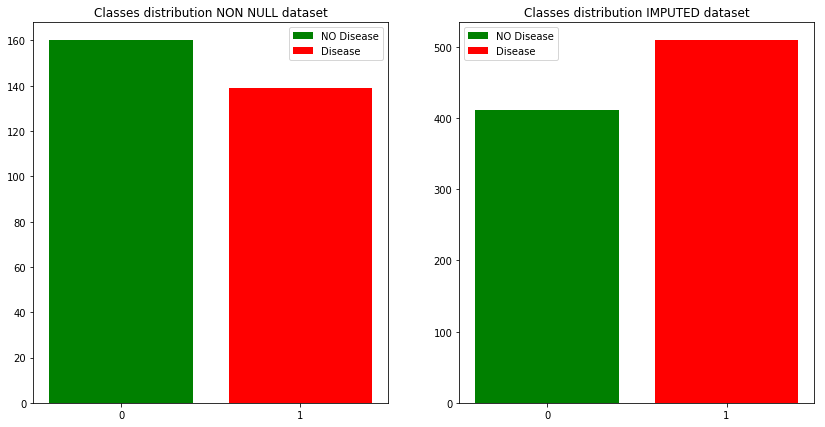

In [55]:
classesColors, classesLegend, datasetTypes= ["green", "red"], ["NO Disease", "Disease"], ["NON NULL", "IMPUTED"]
classes = np.sort(inputDS['class'].unique())
n_classes = classes.size

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for j in range(0, np.size(axes)):
    ds = ds_NoNull if j == 0 else ds_Imp
    classesFrequencies = [ds['class'].loc[ds['class']==0].count(), ds['class'].loc[ds['class']==1].count()]
    
    for i in range(0, n_classes):        
        axes[j].bar(classes[i], classesFrequencies[i], color=classesColors[i], label=classesLegend[i])
        axes[j].set_title("Classes distribution for " + datasetTypes[j])
    axes[j].set_xticks(np.arange(0, 1.1, 1))
    axes[j].set_title("Classes distribution " + datasetTypes[j] + " dataset")
    axes[j].legend()  
plt.show()

We notice that first the classes are not perfectly balanced and then the most frequent class changes between the two dataset.

#### 2.3 - Correlation analysis
We analyze now the degree of correlation between the features in both the datasets using scatterplot matrixes, correlation matrixes and dendrograms.

Scatterplot matrix for the NON NULL dataset:


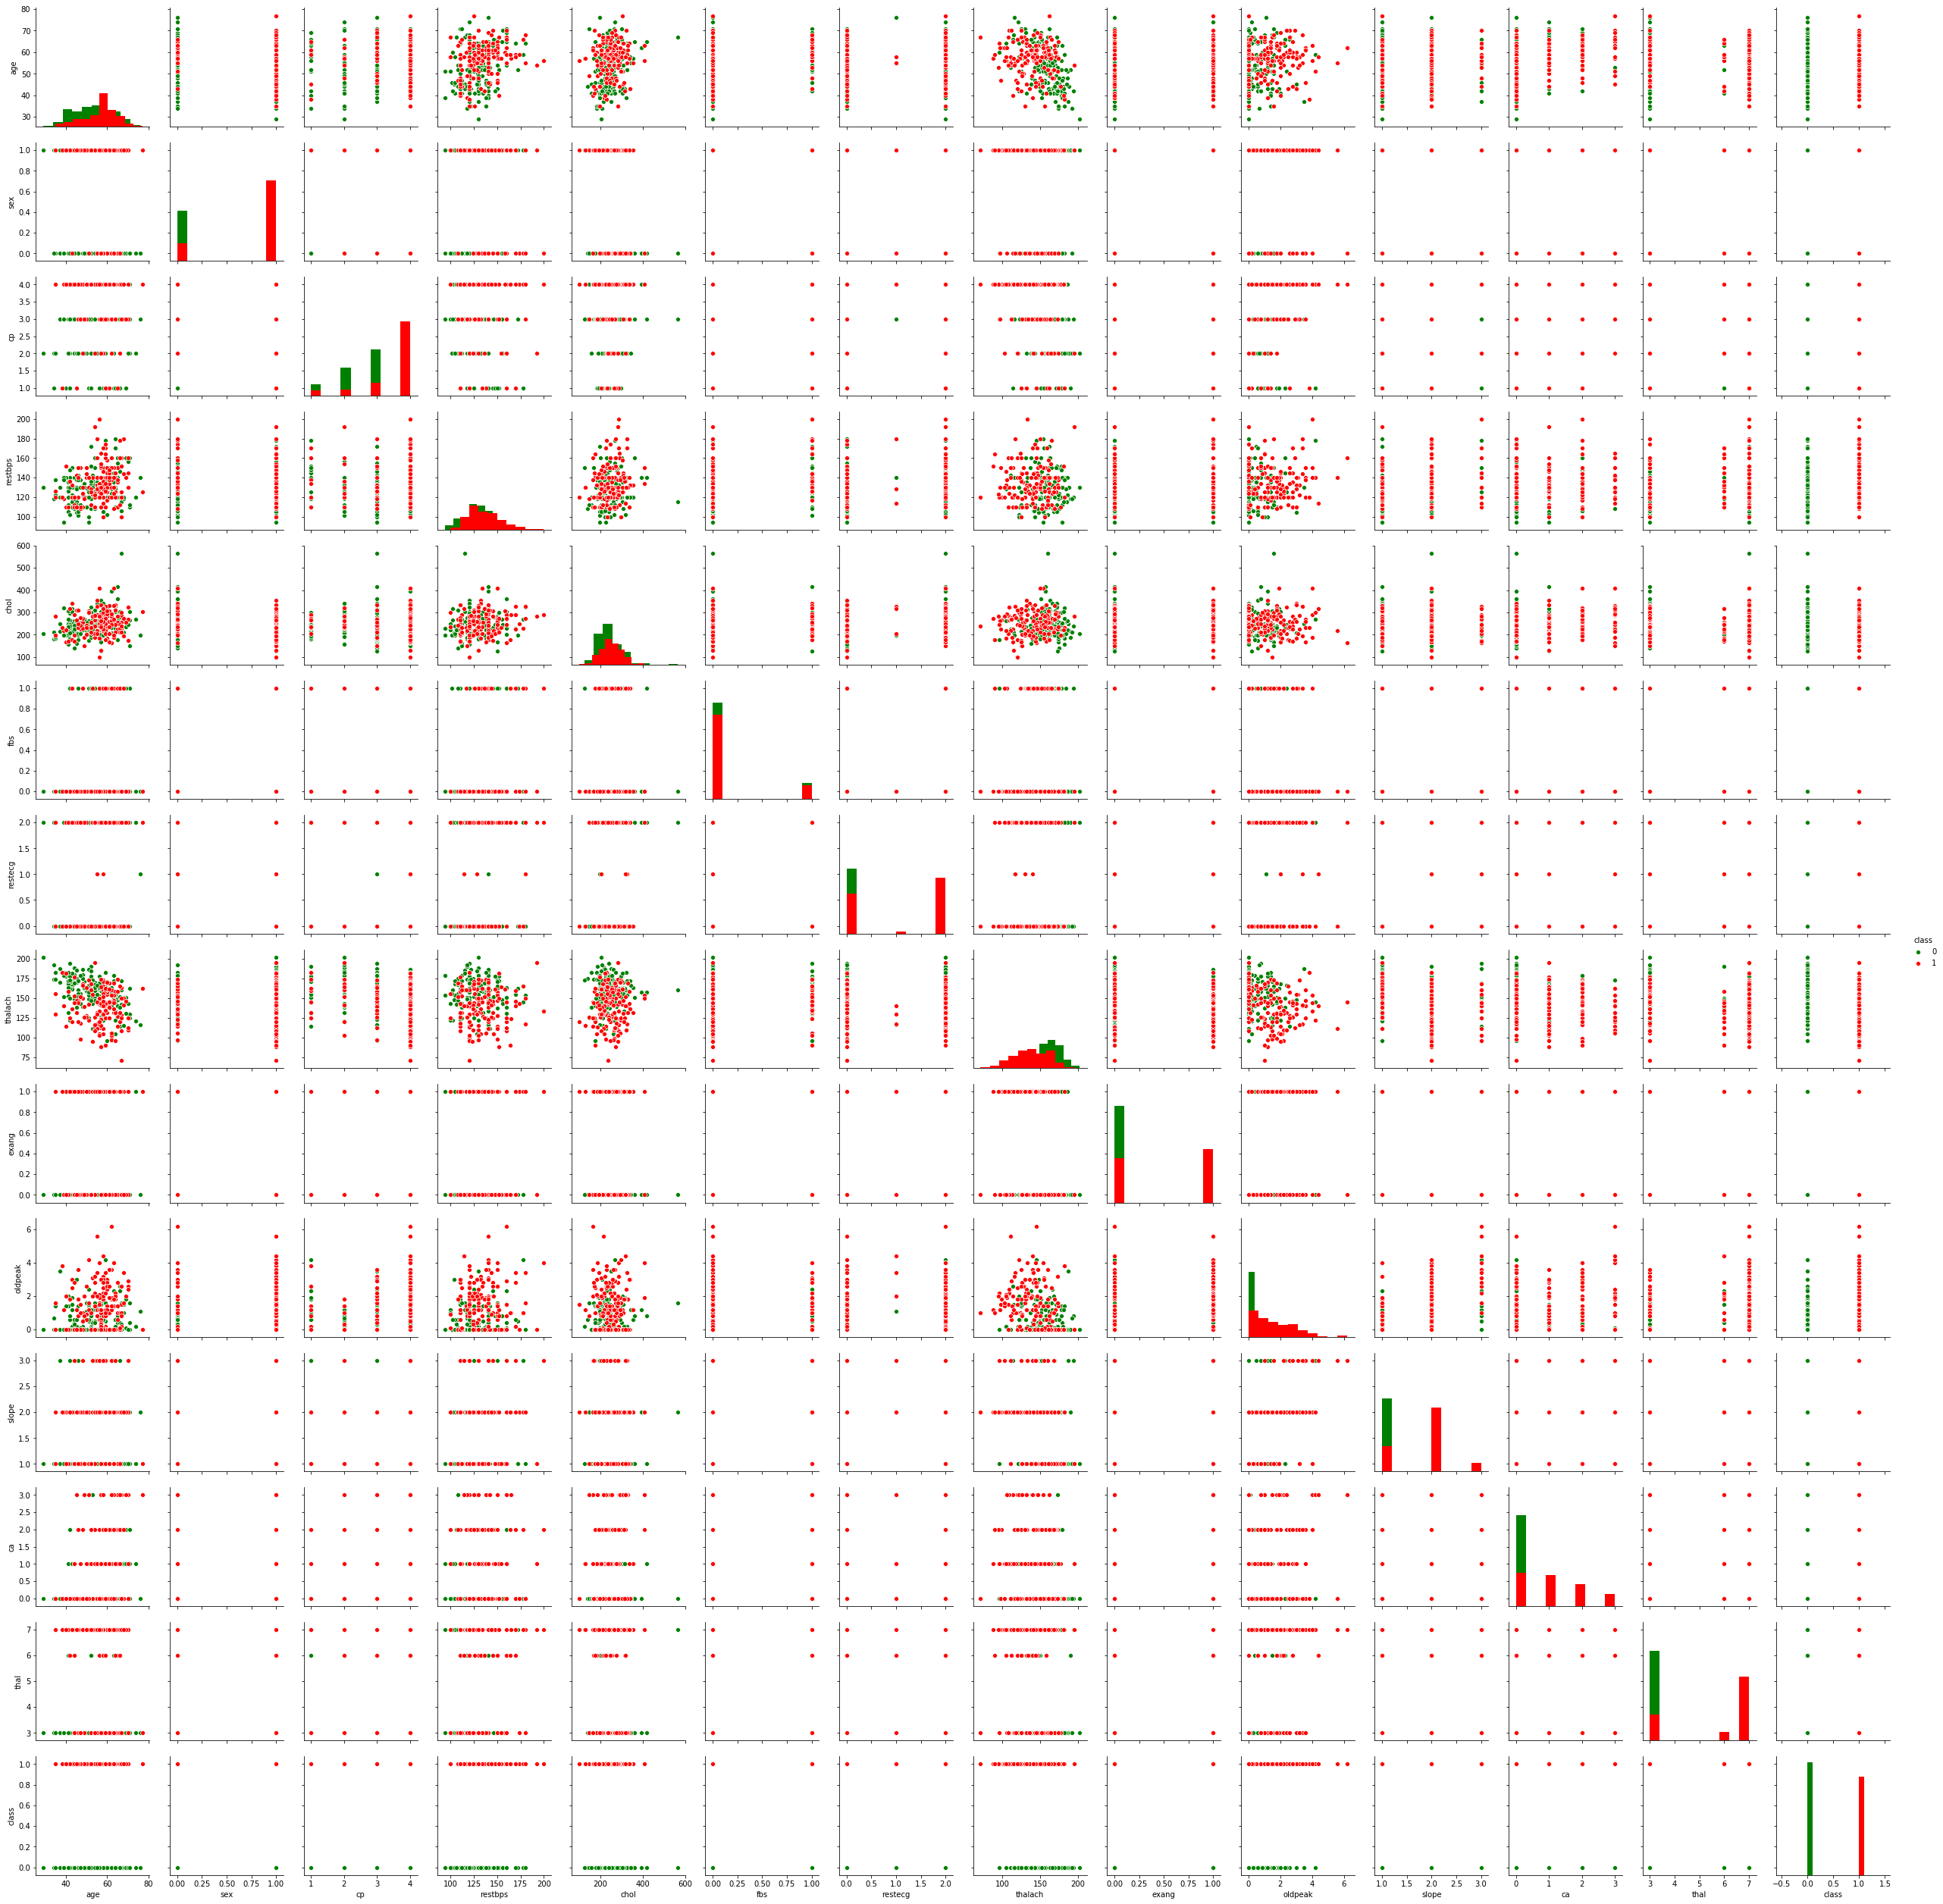

In [66]:
print("Scatterplot matrix for the NON NULL dataset:")
pp = sns.pairplot(ds_NoNull, palette=classesColors, hue='class', diag_kind='hist')
#pp.fig.set_figheight(10), pp.fig.set_figwidth(20)
plt.show()

Scatterplot matrix for the IMPUTED dataset.



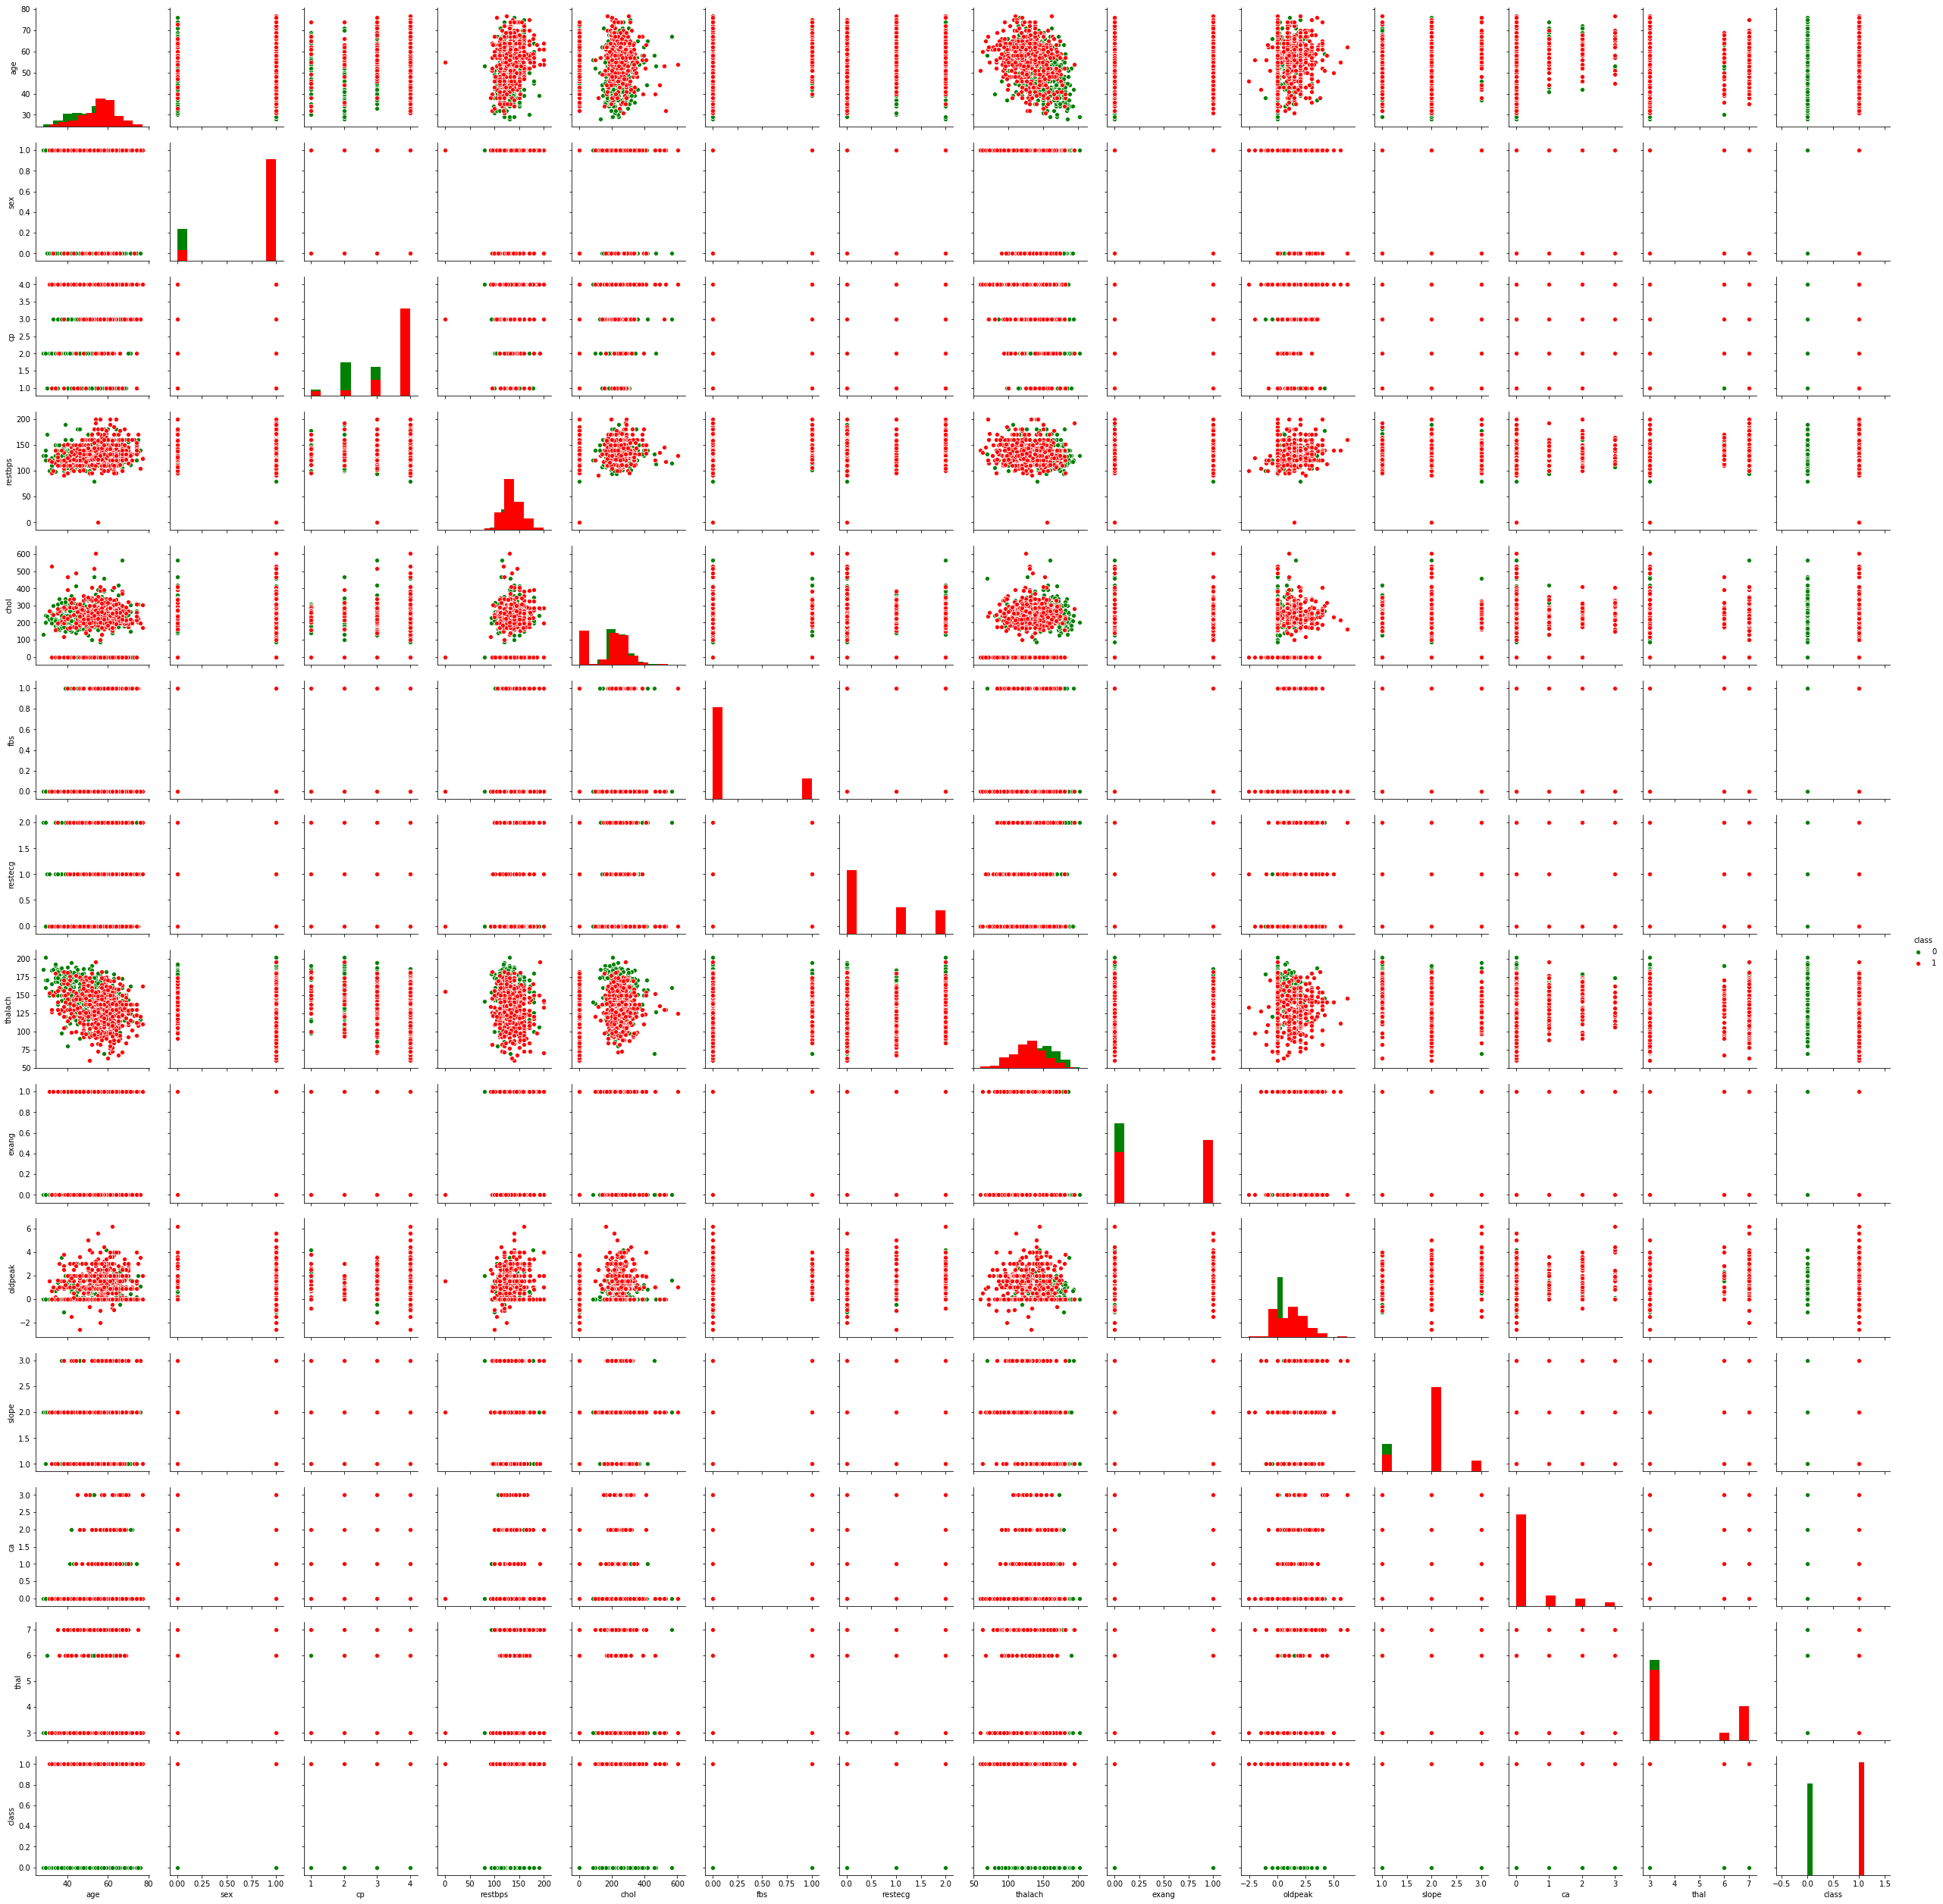

In [57]:
print("Scatterplot matrix for the IMPUTED dataset.\n")
sns.pairplot(ds_Imp, palette=classesColors, hue='class', diag_kind='hist')
plt.show()

Actually the scatterplot matrix is not very readable due to too many considered features, so we use other two tools to analyze the pairwise correlation between features.
<br/>
We compute the _correlation matrix_. The _ij<sup>th</sup>_ cell represents the correlation between the _i<sup>th</sup>_ feature and the _j<sup>th</sup>_ one. Given this definition it is obvious that such a matrix is symmetric and that elements on the diagonal have maximum correlation, therefore we plot only the lower half of the matrix. According to the choosen colors, the more grey the _ij<sup>th</sup>_ cell, the more positively correlated the _i<sup>th</sup>_ and _j<sup>th</sup>_ features, the more red the _ij<sup>th</sup>_ cell, the more negatively correlated the _i<sup>th</sup>_ and _j<sup>th</sup>_ features and the lighter the _ij<sup>th</sup>_ cell, the less correlated the _i<sup>th</sup>_ and _j<sup>th</sup>_ features. There are different way to compute the correlation bewtween two variables and here we use the Pearson definition:

\begin{equation*}
r = \frac{n\sum xy - (\sum x)(\sum y)}{\sqrt{(n\sum x^2 - (\sum x)^2)(n\sum y^2 - (\sum y)^2)}}
\end{equation*}

Where:
- *x , y* : variable we want to compute the correlation of
- *n* : number of pair samples
- *r* : correlation between x and y (-1 $\leq$ r $\leq$ 1)


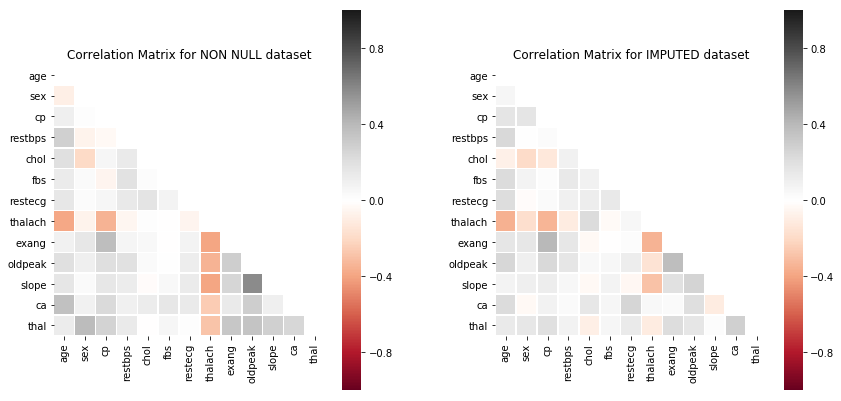

In [58]:
triangular_correlation_matrix((ds_NoNull[attributes[:13]], ds_Imp[attributes[:13]]), ("Non Null", "Imputed"), (14,7))

We represent the correlation between variables using another tool that is _agglomerative hierarchical clustering_. In the most general case the matrix is actually a dissimilarity (or similarity) matrix and the algorithm works in this way:
1. each point is considered a single cluster;
2. compute the dissimilarity matrix
3. REPEAT
 * (3.a) Merge the two closest clusters
 * (3.b) Update the matrix
4. UNTIL only a single cluster remains

Notice that at the point 3.b we remove the rows and columns of the most correlated clusters from the matrix and we add a row and a column for the new cluster containing both the previous two. In our specific case the initial 13 point are the features of the datasets and the considered dissimilarity metric is the just described Pearson correlation. The result of this algorithm can be shown using a dendrogram: on the x axis we have the initial points and on the y axis we have the distances between clusters which depends on the choosen metric. Different colors in the dendrogram indicate different clusters and the more the relative highness of two clusters, the further those clusters. In our case the points are the features of the datasets and the dissimilarity metric is the just described Pearson correlation.

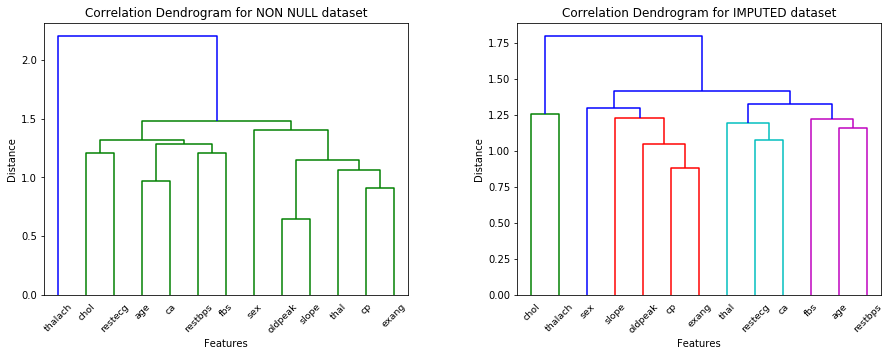

In [91]:
correlation_dendrogram((ds_NoNull[attributes[:13]], ds_Imp[attributes[:13]]), ("Non Null", "Imputed"), (15,5))

Both from the correlation matrix and from the dendrogram we can se that for the NON NULL dataset the most correlated features are:
- _oldpeak_ and _slope_
- _cp_ and _exang_

For the IMPUTED dataset the most correlated features are:
- _cp_ and _exang_
- _restecg_ and _ca_

For both datasets there are not so highly correlated features that would let us to remove one of them.

#### 2.4 Classes distribution
We now analyze by means of bar charts how the two classes are distributed over different values of each attributes to see if there are some attributes that are very discriminative to determine the class of each object. For numeric attributes we first apply discretization dividing the whole domain of the attribute into bins of the same width and then we consider bar for each bins. For categorical attributes we simply consider a bar for each of the distinct values of the domain. For each bin the bars of the two classes are stacked one on the top of the other.

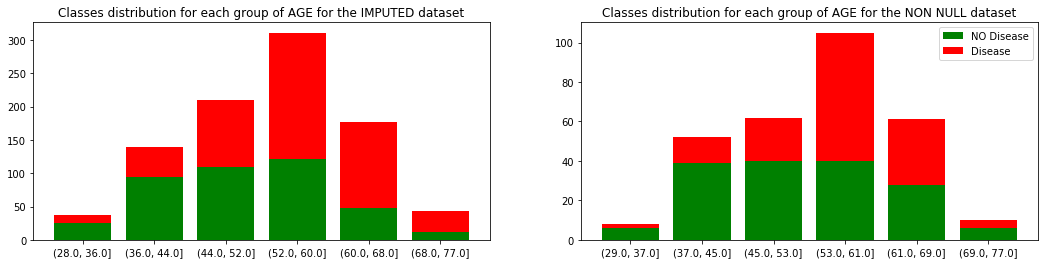

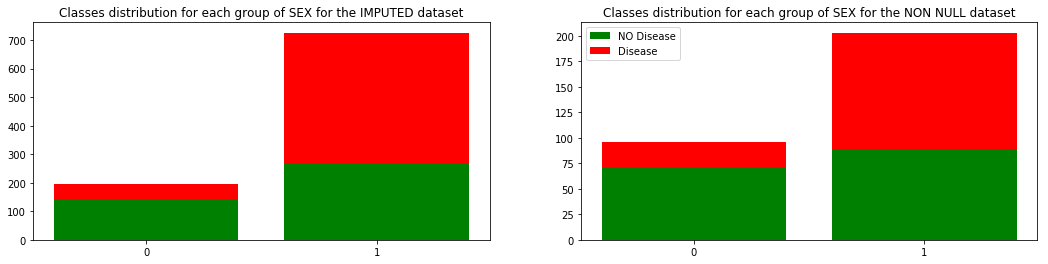

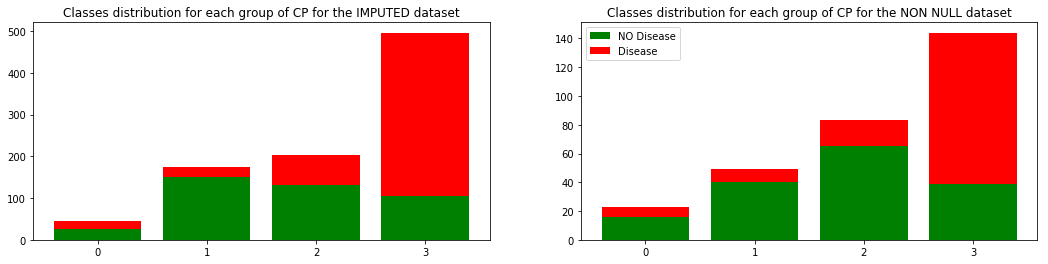

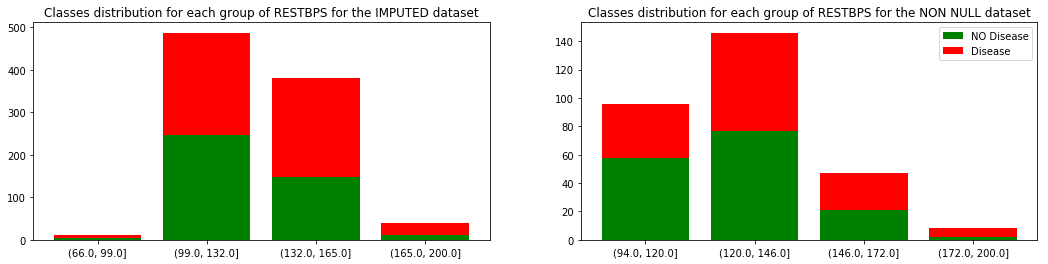

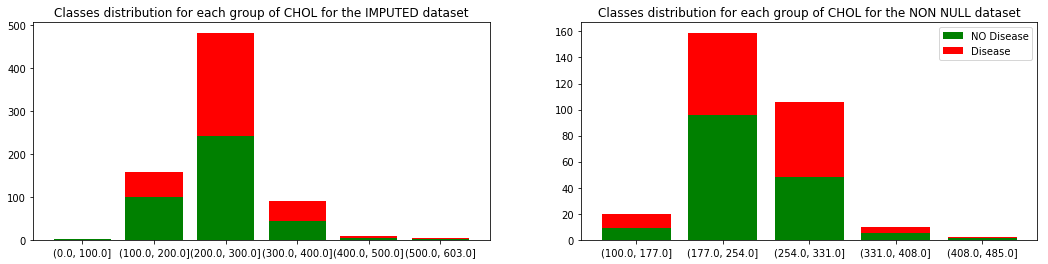

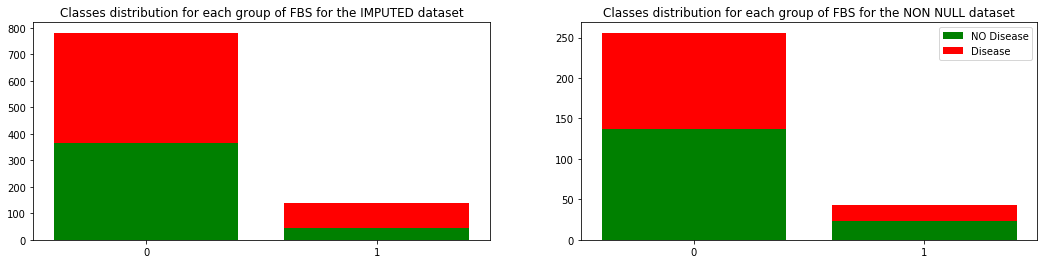

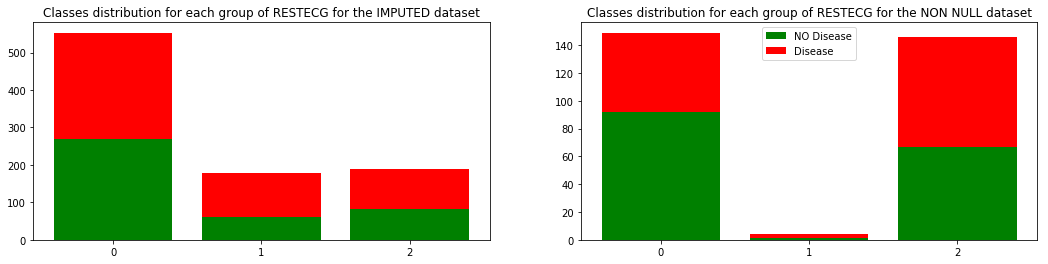

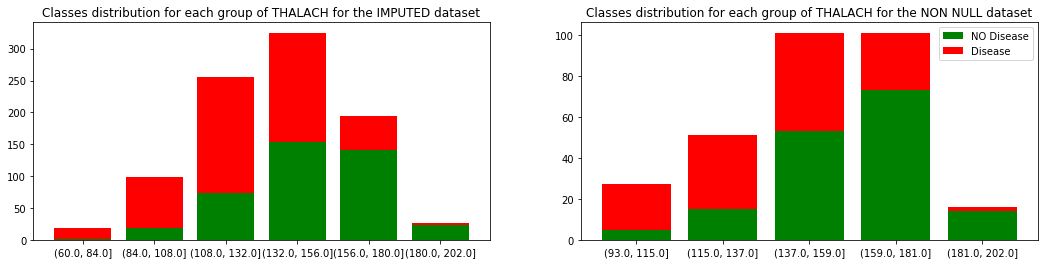

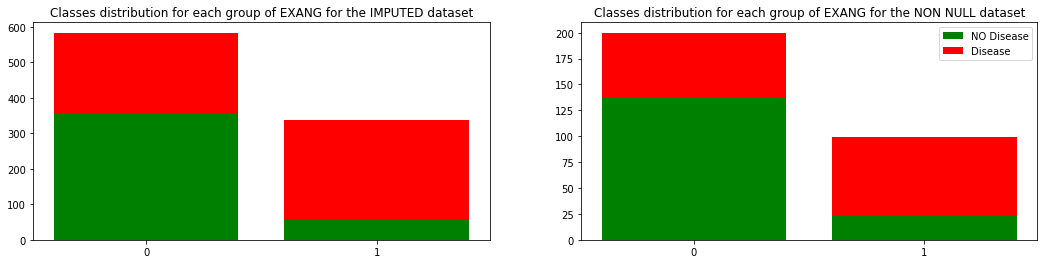

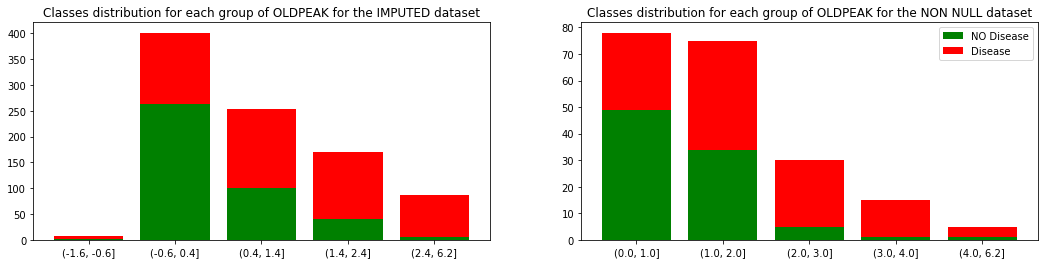

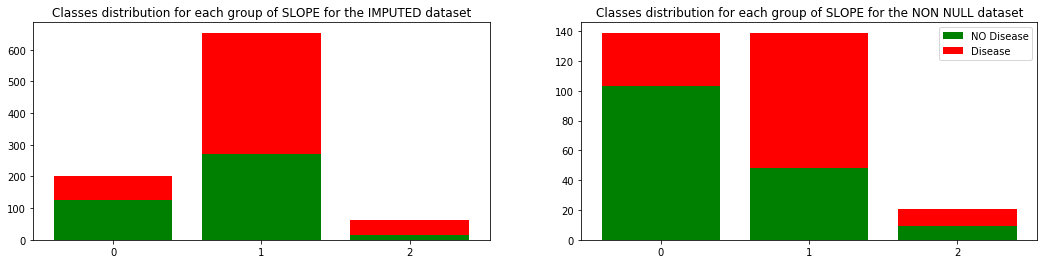

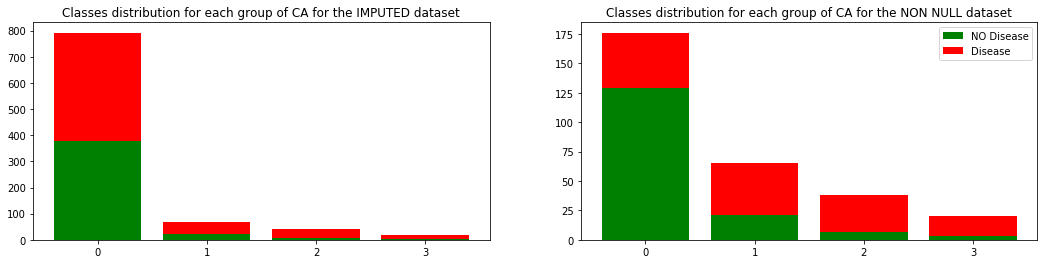

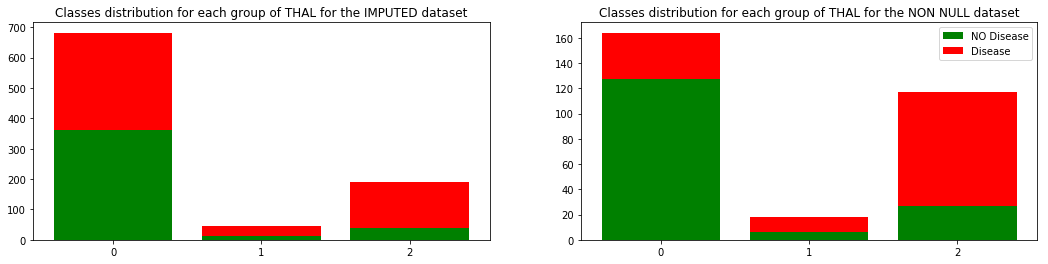

In [35]:
for attribute in attributes:
    if attribute != "class":
        stacked_bar_chart(6, (ds_Imp[attribute], ds_NoNull[attribute]), attribute, (ds_Imp['class'], ds_NoNull['class']), classesColors, classesLegend,(18, 4))

We can notice that for _restbps_, _restecg_, _oldpeak_ and _slope_ the distribution of the two classes over the attributes' values changes a lot between the _IMPUTED_ and _NON NULL_ datasets. In addition for both dataset there are no attributes that are very highly discriminative for the binary classification problem.

## 3 - Classification
Here we come to the core of the report. In fact we apply different classifiers on our data trying to understand which is the best. Each classifier is run using the "best" set of parameters and the complete analysis is done for both the _NON NULL_ and the _IMPUTED_ datasets.

#### 3.1 - Evaluation techniques
We compare the behaviours of different classifiers using different metrics starting from the _confusion matrix_ and in order to do this we consider _NO Disease_ as the _positive_ class and _Diesease_ as the _negative_ class. All these metrics are computed running the classifier with its "best" set of parameters on the test data. In most of the cases we do not have test data, so we split our initial dataset in training data, which will be used to find the "best" set of parameters for a specific classifier, and test data, which will be used to evaluate the specific classifier. The confusion matrix contains the following element:
- _True Positive (TP)_: number of samples correctly assigned to the positive class
- _False Positive (FP)_: number of samples wrongly assigned to the positive class (they actually belong to the negative class)
- _False Negative (FN)_: number of samples wrongly assigned to the negative class (the actually belogn to the positive class)
- _True Negative (TN)_: number of samples correctly assigned to the positive class

A very simple way to evaluate the behaviour of a classifier is to run it and compute the corrisponding _accurancy_ that is the percentage of correctly classified samples with respect to the total number of classified samples. The _accurancy_ is formally defined as follows:

\begin{equation*}
Accurancy = \frac{TP + TN}{TP + FP + FN + TN}
\end{equation*}

Unfortunately the _accurancy_ is not enough to evaluate a classifier. Infact its value is misleading in case the classes are not well balanced. In order to better explain this concept let us assume that we have 90% of the samples that belong to the _positive_ class and the remaining 10% to the _negative_ one; if our classifier simply assigns all samples to the _positive_ class, then we get an accurancy of 90% but a sample will never classified as _negative_. This can be a problem especially if errors have different weights according which class is misclassified. In our case, for example, classifying a sample as _NO Deasease_ while it should actually be classified as _Disease_ (that is a _false positive_) could lead to worse consequences in practice the a _false negative_ error: we are saying that a patient does not run the risk of any heart disease so he will not do any additional checks, but actually he does run the risk of heart disease; on the contrary, for _false negative_ we are saying that a patient runs the risk of a heart disease (even if it is not true) so he will do further checks that will reject the hypoteshis of heart disease.
<br/>
<br/>
In order to overcome this problem we consider another metric to evaluate our classifier, that is the _F1-measure_ which is computed for each class. It is defined as follows:

\begin{equation*}
F1-measure = 2 \frac{precision * recall}{precision + recall}
\end{equation*}

We can notice that this is the harmonic mean of the two elements that are _precision_ and _recall_ that are both computed for each class. 

The _recall_ of a class C is defined as the percentage of samples correctly assigned to the a class with respect to the total number of samples actually belonging to the class C, that formally is:

\begin{equation*}
Recall = \frac{TP}{TP + FN}
\end{equation*}

The _precision_ of a class C is defined as the percentage of samples correctly assigned to the a class with respect to the total number of samples assigned to the class _C_, that formally is:

\begin{equation*}
Precision = \frac{TP}{TP + FP}
\end{equation*}

The best classifier, among those analyzed, is the one that maximizes the F1-measure even if the classes are not balanced, infact increasing the _reacall_, decreases the _precision_ and viceversa.

------------ROC curve------------

#### 3.2 - How do we find the best parameters for a classifier?
The best set of parameters for a classifier is individuated on the basis of the current training data, so if we would consider the same algorithm on different training data, then we could end up in a different set of best parameters for the same classifier. This phase basically consist in:
1. _Training phase_ - train the specific classifier on a portion of the training data with a specific set of parameters
2. _Evaluating phase_ - run the just trained classifier on a different portion of data with respect the point 1 and compute the corresponding statistics (accurancy, f1-measure, etc)
3. Points 1 and 2 are repeated many times changing the parameters of the classifier and at the very end we choose the parameters that gave the best statistics at point 2

Notice that changing the portion of data between points 1 and 2 is extremely important in order to avoid the so called _overfitting_. This phenomenon happens when training and evaluation phase are performed on the same data: statistics like accurancy will be maximized, but the trained algorithm will work extremely bad as soon as data change. As we said before we put aside some data for the final test and we use the remaining data to execute the 3 previous points.
<br/>
A very simple approach is to randomly divide remaining data in actual training data and validation data. Despite of the simplicity of this method, the final result depends on how data have been splitted so the the validation result is not reliable enough. For this reason we do not go for it for selecting the best parameters for every classifier.
<br/>
Instead we use the _K-folds Cross Validation_ technique:
- divide the training data in K splits
- use K-1 splits to train the classifier
- use the remaining split to validate the just trained classifier
- the previous two points are iterated K times and each time the previous validation split joins the training one and a new split is choosen as the validation one
- the mean accurancy over the K iterations is considered as final accurancy (the same for another statistic like f1-measure for example)

Notice that all samples act like validation data exactly once so the final accurancy value is more reliable. In practice we apply the previous procedure many times changing the parameters of the classifier and at the end we choose the set that gave the highest result for the considered metric. In our particular case the metric to be maximized is the _f1-measure_ beacuse the classes are not very well balanced and we want to avoid those problems explained before that could derive by this situation.
<br/><br/>
As we said before here we randomly put aside a 20% of the initial data to be used as test set. Of course this is done for both the datasets considered.

In [69]:
test_size = 0.2
X_train_NoNull, X_test_NoNull, y_train_NoNull, y_test_NoNull = train_test_split(ds_NoNull.drop(['class'], axis=1), ds_NoNull['class'], test_size=test_size, random_state=SEED)
X_train_Imp, X_test_Imp, y_train_Imp, y_test_Imp = train_test_split(ds_Imp.drop(['class'], axis=1), ds_Imp['class'], test_size=test_size, random_state=SEED)

#### 3.3 - Used functions
Here there are some functions defined to implement operation that are in common across the different classifiers.

The *print_CV_results* function prints, using a nice format, the first *first_n_results* results of a grid search cross validation. Paramters are:
- *print_CV_results* - pandas.DataFrame containing the result of the grid search.
- *first_n_results* - first n results that we want to show.
- *classifier_name* - name of the classifier for which the grid search has been executed.

In [163]:
def print_CV_results(cv_results_, first_n_results, classifier_name):
    df_cv_results = pd.DataFrame(cv_results_).sort_values(by='rank_test_score')
    scorer_name = str(gs.scorer_).split('(', 1)[1].split(')')[0]
    
    print("Cross Validation Statistics for %s:" % classifier_name.upper())
    for i in range(1, first_n_results+1):
        iTH_row = df_cv_results.where(df_cv_results['rank_test_score'].astype(int) == i).dropna()
        iTH_row = iTH_row[['mean_test_score', 'std_test_score', 'params']]
        
        for j in range(0, len(iTH_row.index)):
            mean = iTH_row.iloc[j]['mean_test_score']
            std = iTH_row.iloc[j]['std_test_score']
            usedParams = np.array(iTH_row.iloc[j]['params'])
            print(scorer_name + " = %2.6f ± %2.6f for the parameters: %s" %
                  (mean, std, usedParams))
    print()
    return

The *print_confusion_matrix* builds a confusion matrix, starting from the actual and predicted labels and returns a pandas.DataFrame representing it. Parameters are:
- *actual_label* - array containing the actual labels of our data.
- *predicted_label* - array containing the predicted labels of our data.
- *classifier_name* - name of the classifier for which the confusion matrix should be built.

In [ ]:
def print_confusion_matrix(actual_label, predicted_label, classifier_name):
    print("\nConfusion Matrix for " + classifier_name.upper())
    cm = confusion_matrix(actual_label, predicted_label)
    return pd.DataFrame(cm.round(3), index=["Actual NO Desease - 0", "Actual Desease - 1"],
                 columns=["Predicted NO Desease - 0", "Predicted Desease - 1"])

The *print_statistics* functions returns a pandas.DataFrame containing accurancy, precision, recall and f1-measure starting from a given confusion matrix. Parameters are:
- *confusionMatrix* - pandas.DataFrame containing the consufion matrix for a classifier.
- *classifier_name* - name of the classifier for which statistics should be computed.

In [ ]:
def print_statistics(confusionMatrix, classifier_name):
    tn, fp, fn, tp = confusionMatrix.as_matrix().ravel()
    accurancy = (tn + tp) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    data = np.array([['Accurancy', 'Precision', 'Recall', 'F1-measure'],
                     [accurancy, precision, recall, f1]])
    print("\nStatistics for " + classifier_name.upper())
    return pd.DataFrame(data=data[1:,0:], columns=data[0,0:])

The *plot_tree_feature_importances* function plots a horizontal bar chart representing the importance of different features in classifiers like trees or random forests. Parameters are:
- _features_ - arrays contaning the name of the features.
- _figsize_ - figsize attributes of the plot to be created.
- *feature_importances* - array contaning values representing the importance of each feature.
- _width_ - width of each bar in the plot to be created.
- *classifier_name* - name of the classifier for which the chart should be created.

In [ ]:
def plot_tree_feature_importances(features, figsize, feature_importances, width, classifier_name):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    y_pos = np.arange(0, len(features), width)
    ax.barh(y_pos, feature_importances)    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.invert_yaxis()  # labels read top-to-bottom
    #ax.set_xticks(np.arange(0, 1+0.1, 0.1))
    ax.set_xlabel('Feature importances')
    ax.set_ylabel('Features')
    ax.set_title("Feature importances for the " + classifier_name.upper())
    plt.show()
    return

The *plot_learning_curve* function is a slight modification of the one at https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html. It generate a simple plot of the training and cross validation learning curve, that are curves representing how the accurancy varies according to the number of training sample involved, measuring the accurancy on the training samples and by means of K-folds cross validation respectively. Parameters modified or added with respetc to the original version are:
- *classifier_name* instead of *title* - name of the classifier for which the learning curves should be created.
- *figsize* - figsize attributes of the plot to be created.
- *colors* - array of 2 elements; the first indicates the color for the training curve, the second the one for the learning curve.

In [ ]:
def plot_learning_curve(estimator, classifier_name, X, y, ylim=None, cv=None, n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5), figsize=None, colors=['g', 'r']):
    plt.figure(figsize=figsize)
    plt.title("Learning curve for " + classifier_name.upper())
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Number of training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color=colors[0])
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=colors[1])
    plt.plot(train_sizes, train_scores_mean, 'o-', color=colors[0],
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color=colors[1],
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    return

#### 3.4 - Decision Tree

In [164]:
DECISION_TREE_HP = {
    'max_depth': [7, 10, 13],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [10, 14, 18],
}



clf = DecisionTreeClassifier(random_state=SEED)
gs = GridSearchCV(clf, DECISION_TREE_HP, cv=10, n_jobs=-1, scoring='f1', return_train_score=False, verbose=-1)
gs.fit(X_train, y_train)

print_CV_results(gs.cv_results_, 5, "Decision Tree")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Cross Validation Statistics for DECISION TREE:
f1_score = 0.796610 ± 0.039480 for the parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 18}
f1_score = 0.791163 ± 0.035441 for the parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 14}
f1_score = 0.786788 ± 0.039927 for the parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 10}
f1_score = 0.780463 ± 0.044854 for the parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 18}
f1_score = 0.780267 ± 0.045991 for the parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}



[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.6s finished


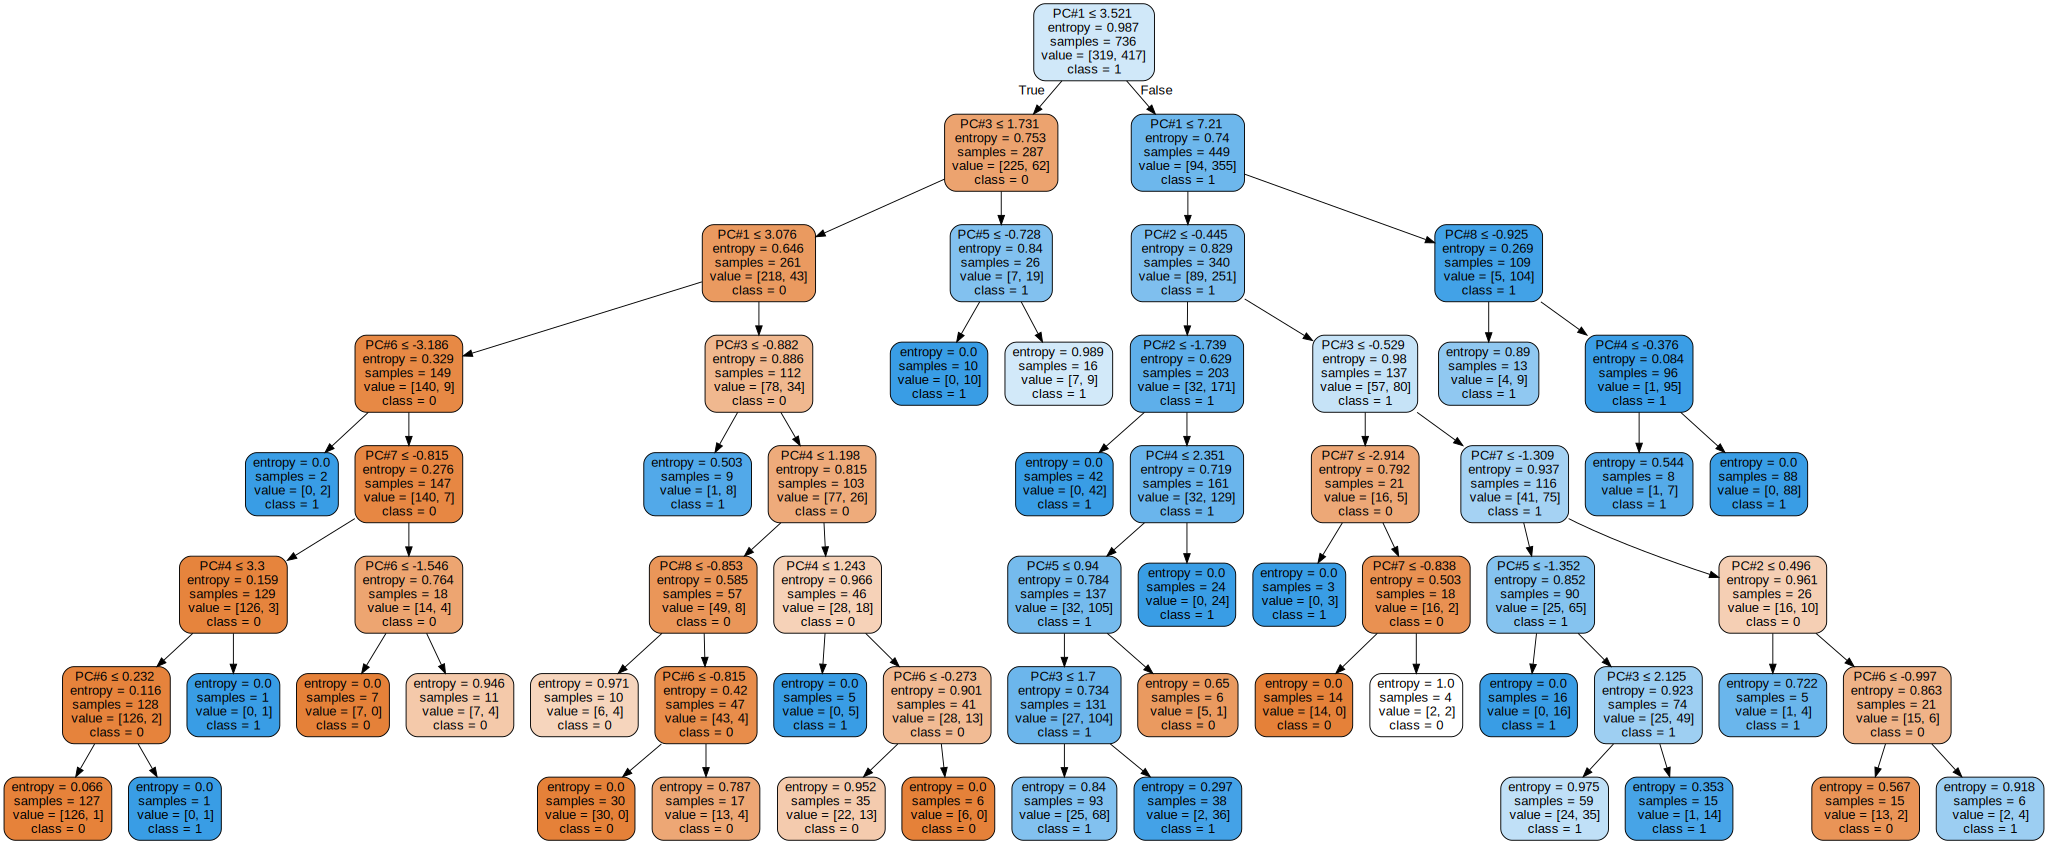

In [165]:
dot_data = export_graphviz(gs.best_estimator_, feature_names=X_train.columns.values, class_names=['0', '1'],
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph

In [166]:
bestClf = gs.best_estimator_
confusionMatrix = print_confusion_matrix(np.array(y_test), bestClf.predict(X_test), "Decision Tree")
confusionMatrix


Confusion Matrix for DECISION TREE


,Predicted NO Desease - 0,Predicted Desease - 1
Actual NO Desease - 0,72,20
Actual Desease - 1,15,77


In [167]:
print_statistics(confusionMatrix, "Decision Tree")


Statistics for DECISION TREE


,Accurancy,Precision,Recall,F1-measure
0,0.8097826086956522,0.7938144329896907,0.8369565217391305,0.8148148148148148


ValueError: shape mismatch: objects cannot be broadcast to a single shape

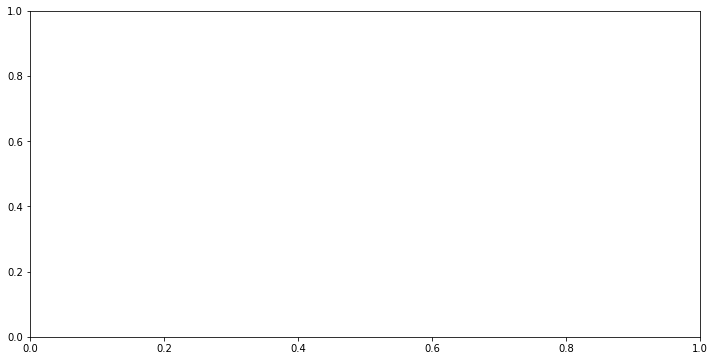

In [168]:
plot_tree_feature_importances(ds_Imp.drop(columns=['class']).columns.values, (12,6),
                              bestClf.feature_importances_, 1.0, "Decision Tree")

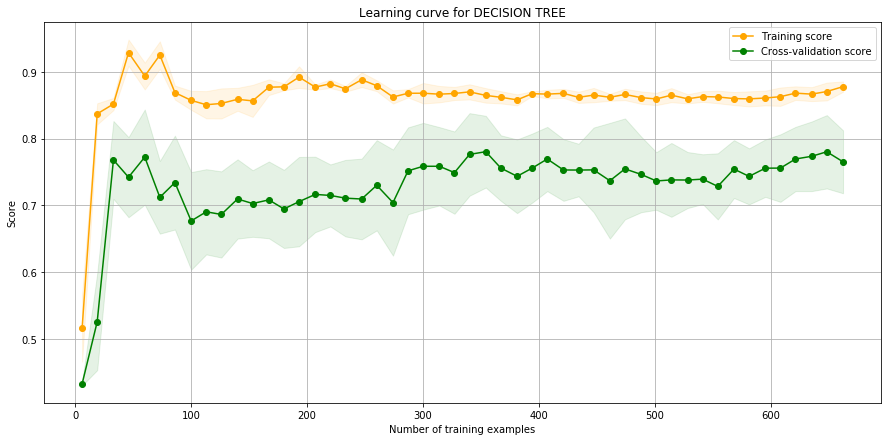

In [161]:
plot_learning_curve(bestClf, "Decision Tree", X_train, y_train, cv=10,
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), figsize=(15,7), colors=['orange', 'green'])

### CLASSIFICATION TREE - BAGGING

In [ ]:
minTrees, maxTrees = 1, 10
n_trees = np.arange(minTrees, maxTrees+1)

scores, errorRates = np.zeros((maxTrees-minTrees+1, 2)), np.zeros((maxTrees-minTrees+1, 2))
featureImportances = np.zeros(np.size(X_train.columns.values))

i, j = 0, 0
for trees in n_trees:
    
    base_estimator = DecisionTreeClassifier(max_depth=len(X_train.columns.values), random_state=SEED, min_samples_split=10)
       
    singleBaggingfeatureImportances = np.zeros(np.size(X_train.columns.values))
    clf = BaggingClassifier(base_estimator=base_estimator, n_estimators=trees, bootstrap=True, random_state=SEED)
    clf.fit(X_train, y_train)
    
    # training data
    scores[i][0] = clf.score(X_train, y_train)
    errorRates[i][0] = 1 - scores[i][0]
    
    # test data
    scores[i][1] = clf.score(X_test, y_test)
    errorRates[i][1] = 1 - scores[i][1]
    
    for singleFittedTree in clf.estimators_:
        singleBaggingfeatureImportances += singleFittedTree.feature_importances_
    singleBaggingfeatureImportances /= np.size(clf.estimators_)
    featureImportances += singleBaggingfeatureImportances
    
    i += 1

featureImportances /= np.size(n_trees)

# plot accurancy percentage and error rate
colors = ['orange', 'purple']
labels = ['Training data', 'Test data']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
for i in range(0, 2):
    ax1.plot(n_trees, scores[:,i], label=labels[i], color=colors[i])
    ax2.plot(n_trees, errorRates[:,i], label=labels[i], color=colors[i])
plt.legend()
for ax in (ax1, ax2):
    ax.set_xticks(np.arange(0, np.size(n_trees)+1, 10))
    ax.set_xlabel("Number of trees")
ax1.set_ylabel("Accurancy %")
ax2.set_ylabel("Error rate")
plt.show()

In [ ]:
plot_tree_feature_importances(ds_Imp.drop(columns=['class']).columns.values, (12,6),
                              featureImportances, 1.0, "Bagging Decision Tree")

### CLASSIFICATION TREE - RANDOM FOREST

In [ ]:
RANDOM_FOREST_HP = {
    'max_depth': [7, 10, 13],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [10, 14, 18],
    'max_features': ['sqrt']
}

minTrees, maxTrees = 1, 10
n_trees = np.arange(minTrees, maxTrees+1)

scores, errorRates = np.zeros((maxTrees-minTrees+1, 2)), np.zeros((maxTrees-minTrees+1, 2))
featureImportances = np.zeros(np.size(X_train.columns.values))

for trees in n_trees:
    
    clf = RandomForestClassifier(n_estimators=trees, random_state=SEED)
    gs = GridSearchCV(clf, RANDOM_FOREST_HP, cv=10, n_jobs=-1, scoring='f1', return_train_score=False)
    gs.fit(X_train, y_train)
    bestClf = gs.best_estimator_
    
    # training data
    scores[trees-1][0] = bestClf.score(X_train, y_train)
    errorRates[trees-1][0] = 1 - scores[trees-1][0]
    
    # test data
    scores[trees-1][1] = bestClf.score(X_test, y_test)
    errorRates[trees-1][1] = 1 - scores[trees-1][1]
    
    featureImportances += bestClf.feature_importances_

featureImportances /= np.size(n_trees)

# plot accurancy percentage and error rate
colors = ['orange', 'purple']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
for i in range(0, 2):
    ax1.plot(n_trees, scores[:,i], label=labels[i], color=colors[i])
    ax2.plot(n_trees, errorRates[:,i], label=labels[i], color=colors[i])
plt.legend()
for ax in (ax1, ax2):
    ax.set_xticks(np.arange(0, np.size(n_trees)+1, 10))
    ax.set_xlabel("Number of trees")
ax1.set_ylabel("Accurancy %")
ax2.set_ylabel("Error rate")
plt.show()

In [ ]:
plot_tree_feature_importances(ds_Imp.drop(columns=['class']).columns.values, (12,6),
                              featureImportances, 1.0, "Random Forest")

### SUPPORT VECTOR MACHINE

In [ ]:
LINEAR_SVM_HP = {
    'C': [0.01, 0.1]
}

RBF_SVM_HP = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10]
}

In [ ]:
clf = SVC(kernel='linear', random_state=SEED)
gs = GridSearchCV(clf, LINEAR_SVM_HP, cv=3, n_jobs=3, scoring='f1', return_train_score=False)
gs.fit(X_train, y_train)

print_CV_results(gs.cv_results_, 5, "Linear SVM")

In [ ]:
bestClf = gs.best_estimator_
confusionMatrix = print_confusion_matrix(np.array(y_test), bestClf.predict(X_test), "Linear SVM")
confusionMatrix

In [ ]:
print_statistics(confusionMatrix, "Linear SVM")

In [ ]:
plot_learning_curve(bestClf, "Linear SVM", X_train, y_train, cv=10,
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), figsize=(15,7), colors=['orange', 'green'])

In [ ]:
clf = SVC(kernel='rbf', random_state=SEED)
gs = GridSearchCV(clf, RBF_SVM_HP, cv=10, n_jobs=3, scoring='f1', return_train_score=False)
gs.fit(X_train, y_train)

print_CV_results(gs.cv_results_, 5, "RBF SVM")

In [ ]:
bestClf = gs.best_estimator_
confusionMatrix = print_confusion_matrix(np.array(y_test), bestClf.predict(X_test), "RBF SVM")
confusionMatrix

In [ ]:
print_statistics(confusionMatrix, "RBF SVM")

In [ ]:
plot_learning_curve(bestClf, "RBF SVM", X_train, y_train, cv=10,
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), figsize=(15,7), colors=['orange', 'green'])

### KNN

In [ ]:
KNN_HP = {
    'n_neighbors': [1, 2, 3, 4],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 5, 10]
}

clf = KNeighborsClassifier()
gs = GridSearchCV(clf, KNN_HP, cv=10, n_jobs=-1, scoring='f1', return_train_score=False)
gs.fit(X_train, y_train)
bestClf = gs.best_estimator_

print_CV_results(gs.cv_results_, 5, "K-Nearest Neighbors")

In [ ]:
bestClf = gs.best_estimator_
confusionMatrix = print_confusion_matrix(np.array(y_test), bestClf.predict(X_test), "K-Nearest Neighbors")
confusionMatrix

In [ ]:
print_statistics(confusionMatrix, "K-Nearest Neighbors")

In [ ]:
plot_learning_curve(bestClf, "K-Nearest Neighbors", X_train, y_train, cv=10,
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), figsize=(15,7), colors=['orange', 'green'])

### LOGISTIC REGRESSION

In [ ]:
LOGISTIC_REGRESSION_HP = {
    'C': [0.001, 0.1, 1, 10],
    'solver': ['liblinear'],
    'penalty': ['l2', 'l1'],
    'tol': [0.00001, 0.0001, 0.001, 0.01, 0.1]
}

clf = LogisticRegression(random_state=SEED)
gs = GridSearchCV(clf, LOGISTIC_REGRESSION_HP, cv=5, n_jobs=2, scoring='f1', return_train_score=False)
gs.fit(X_train, y_train)
bestClf = gs.best_estimator_

print_CV_results(gs.cv_results_, 5, "Logistic Regression")

In [ ]:
bestClf = gs.best_estimator_
confusionMatrix = print_confusion_matrix(np.array(y_test), bestClf.predict(X_test), "Logistic Regression")
confusionMatrix

In [ ]:
print_statistics(confusionMatrix, "Logistic Regression")

In [ ]:
plot_learning_curve(bestClf, "Logistic Regression", X_train, y_train, cv=10,
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50), figsize=(15,7), colors=['orange', 'green'])